# Лабораторная работа №1 
## Проведение исследований с алгоритмом KNN

### 1. Выбор начальных условий

#### a. Набор данных для задачи классификации

Diabetes prediction dataset - https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

Набор данных для прогнозирования диабета представляет собой набор медицинских и демографических данных пациентов, включая информацию об их статусе диабета (положительный или отрицательный). Эти данные включают такие характеристики, как возраст, пол, индекс массы тела (ИМТ), гипертония, заболевания сердца, анамнез курения, уровень HbA1c и уровень глюкозы в крови. Этот набор данных может быть использован для построения моделей машинного обучения для прогнозирования диабета у пациентов на основе их истории болезни и демографической информации. Это может быть полезно медицинским работникам для выявления пациентов с потенциальным риском развития диабета и разработки индивидуальных планов лечения. Кроме того, этот набор данных может быть использован исследователями для изучения взаимосвязи между различными медицинскими и демографическими факторами и вероятностью развития диабета.

#### b. Набор данных для задачи регрессии

Honey purity dataset - https://www.kaggle.com/datasets/stealthtechnologies/predict-purity-and-price-of-honey

Набор данных для прогнозирования качества и цены мёда. Решение данной задачи будет полезно пчеловодам для контроля качества их продукции и обоснования ее цены.


#### c. Выбор метрик качества

##### Задача классификации:

1) $Fbeta-score$ - основная метрика. Т.к. классы несбалансированы (здоровых людей больше чем, больных диабетом), то accuracy может быть обманчивой. $Fbeta-score$ учитывает $precision$ и $recall$, что подходит для медицинской диагностики, где важно найти найти как можно больше больных (высокий $recall$), но при этом не напугать здоровых (высокий $precision$). Дает больший вес $recall$ метрике при возрастании $beta$. $beta = 1,2,3, ...$

2) $Recall$ - показывает сколько из всех рельно больных мы нашли.

3) $Precision$ - показывает сколько из всех предсказанных больных действительно больны.

4) $Accuracy$ - дополнительная метрика для общего понимания доли верных ответов.

##### Задача регрессии:

1) $MAE$ - показывает среднюю абсолютную ошибку в условных ед. Легко интерпретируется (В среднем модель ошибается на N у.е.).

2) $RMSE$ - более строгая метрика, которая сильнее штрафует за большие ошибки предсказания.

3) $R^2$ - показывает насколько модель предсказывает лучше, чем среднее значение.

### 2. Создание бейзлайна и оценка качества

#### 2.1. Обучение моделей из sklearn для решения задачи классификации и оценка качества по выбранным метрикам.

0. Подключим необходимые модули

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, make_scorer

1. Загрузим датасет и посмотрим, что он из себя представляет

In [2]:
diabetes_df = pd.read_csv("datasets/diabetes_prediction_dataset.csv")
diabetes_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


Посмотрим информацию о датасете

In [ ]:
print(diabetes_df.info())
diabetes_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


Посмотрим сколько у нас null столбцев

In [4]:
diabetes_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Посмотрим сколько у нас повторяющихся строк

In [5]:
diabetes_df.duplicated().sum()

np.int64(3854)

Посмотрим информацию о категориальных данных

In [6]:
print(diabetes_df['gender'].value_counts())
print(diabetes_df['smoking_history'].value_counts())

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64
smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64


2. Сделаем минимально необходимую обработку и обучим модели: 

In [7]:
gender_dummies = pd.get_dummies(diabetes_df['gender'], drop_first=True)
smoking_history_dummies = pd.get_dummies(diabetes_df['smoking_history'], drop_first=True)
onehot_diabetes_df = pd.concat([diabetes_df, gender_dummies, smoking_history_dummies], axis=1)

onehot_diabetes_df.drop(['gender', 'smoking_history'], axis=1, inplace=True)

Разделим датафрейм на features и target, а также train и test

In [8]:
diabetes_X = onehot_diabetes_df.drop('diabetes', axis=1)
diabetes_y = onehot_diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42
)

Кросс-валидация и выбор лучшей модели по fbeta-score (beta = 1,2,3)

In [9]:
from matplotlib import pyplot as plt
from sklearn.base import clone
from sklearn.metrics import classification_report, precision_recall_curve

model = KNeighborsClassifier()

def find_optimal_threshhold_cv(model, X, y, cv=5, f_beta=1, eps=1e-9, report=False):
    skf = StratifiedKFold(n_splits=cv)
    fold_scores = []
    models = []
    thresholds = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        fold_model = clone(model)
        fold_model.fit(X_train, y_train)
        models.append(fold_model)
        
        y_prob_val = fold_model.predict_proba(X_val)[:, 1]
        prec, rec, thresh = precision_recall_curve(y_val, y_prob_val)
        f_beta_scores = (1 + f_beta ** 2) * (prec * rec) / ((f_beta ** 2 * prec) + rec + eps)
        optimal_thresh_fold = thresh[f_beta_scores.argmax()]
        thresholds.append(optimal_thresh_fold)
        
        y_pred_val = (y_prob_val >= optimal_thresh_fold).astype(int)
        fold_scores.append({
            'classification_report': classification_report(y_val, y_pred_val),
            'f1_score': fbeta_score(y_val, y_pred_val, beta=1),
            'f2_score': fbeta_score(y_val, y_pred_val, beta=2),
            'f3_score': fbeta_score(y_val, y_pred_val, beta=3),
            'f_beta_score': fbeta_score(y_val, y_pred_val, beta=f_beta)
        })
    
    best_fold_idx = np.argmax([f['f_beta_score'] for f in fold_scores])
    best_model = models[best_fold_idx]
    best_threshold = thresholds[best_fold_idx]
    best_fold_score = fold_scores[best_fold_idx]
    
    if report:        
        print(f"\n=== Best Model f{f_beta} on validation ===")
        print(f"Best fold: {best_fold_idx + 1}")
        print(best_fold_score['classification_report'])
        print(f"Best f1-score: {best_fold_score['f1_score']:.4f}")
        print(f"Best f2-score: {best_fold_score['f2_score']:.4f}")
        print(f"Best f3-score: {best_fold_score['f3_score']:.4f}")
        print(f"Best f{f_beta}-score: {best_fold_score['f_beta_score']:.4f}")
        print(f"Best threshold: {best_threshold}")
    
    return best_model, best_threshold, best_fold_score
    

optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for f_score in [1, 2, 3]:
    optimal_models[f'f{f_score}'], optimal_thresholds[f'f{f_score}'], optimal_fold_scores[f'f{f_score}'] = find_optimal_threshhold_cv(
        model,
        diabetes_X_train,
        diabetes_y_train,
        cv=5,
        f_beta=f_score,
        report=True
    )
    


=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     14640
           1       0.70      0.65      0.67      1360

    accuracy                           0.95     16000
   macro avg       0.83      0.81      0.82     16000
weighted avg       0.94      0.95      0.95     16000

Best f1-score: 0.6725
Best f2-score: 0.6579
Best f3-score: 0.6532
Best f1-score: 0.6725
Best threshold: 0.4

=== Best Model f2 on validation ===
Best fold: 2
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     14640
           1       0.43      0.82      0.56      1360

    accuracy                           0.89     16000
   macro avg       0.71      0.86      0.75     16000
weighted avg       0.93      0.89      0.91     16000

Best f1-score: 0.5648
Best f2-score: 0.6938
Best f3-score: 0.7510
Best f2-score: 0.6938
Best threshold: 0.2

=== Best Model f3 on validati

Проведем замеры на тестовой выборке

In [10]:
for f_score in [1, 2, 3]:
    model = optimal_models[f'f{f_score}']
    threshold = optimal_thresholds[f'f{f_score}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{f_score} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{f_score}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=f_score):.4f}")    


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     18300
           1       0.67      0.64      0.65      1700

    accuracy                           0.94     20000
   macro avg       0.82      0.81      0.81     20000
weighted avg       0.94      0.94      0.94     20000

f1-score: 0.6547
f2-score: 0.6483
f3-score: 0.6462
f1-score: 0.6547

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     18300
           1       0.41      0.80      0.54      1700

    accuracy                           0.88     20000
   macro avg       0.69      0.85      0.74     20000
weighted avg       0.93      0.88      0.90     20000

f1-score: 0.5412
f2-score: 0.6723
f3-score: 0.7313
f2-score: 0.6723

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     18300
           1       0.41      0.8

Вывод: несмотря на неплохой accuracy от 0.89 до 0.95 в зависимости от метрики, которую мы хотим оптимизировать. Видно следующее при вменяемом precision = 0.88 для определения класса "есть диабет", recall очень низкий. При стремлении увеличить recall начинает страдать precision, причем очень сильно. Это более заметно для класса "есть диабет", т.к. таких значений в разы меньше. 

### 3. Улучшение бейзлайна

#### 3.1. Задача классификации

0. Подключение модулей

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

1. Проведем более детальный анализ датасета

Вспомним, что из себя представляет датасет

In [12]:
print(f"Количество строк: {diabetes_df.shape[0]}, столбцев {diabetes_df.shape[1]}")
print(diabetes_df.info(), diabetes_df.describe())
diabetes_df.head()

Количество строк: 100000, столбцев 9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None                  age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840  

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


Посмотрим сколько значений пропущено

In [13]:
diabetes_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Какие есть уникальные категориальные значения

In [14]:
print(diabetes_df['gender'].value_counts())
print(diabetes_df['smoking_history'].value_counts())

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64
smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64


Построим графики распределения всех людей и тех у кого диабет.

Синий - нет диабета.

Красный - есть.

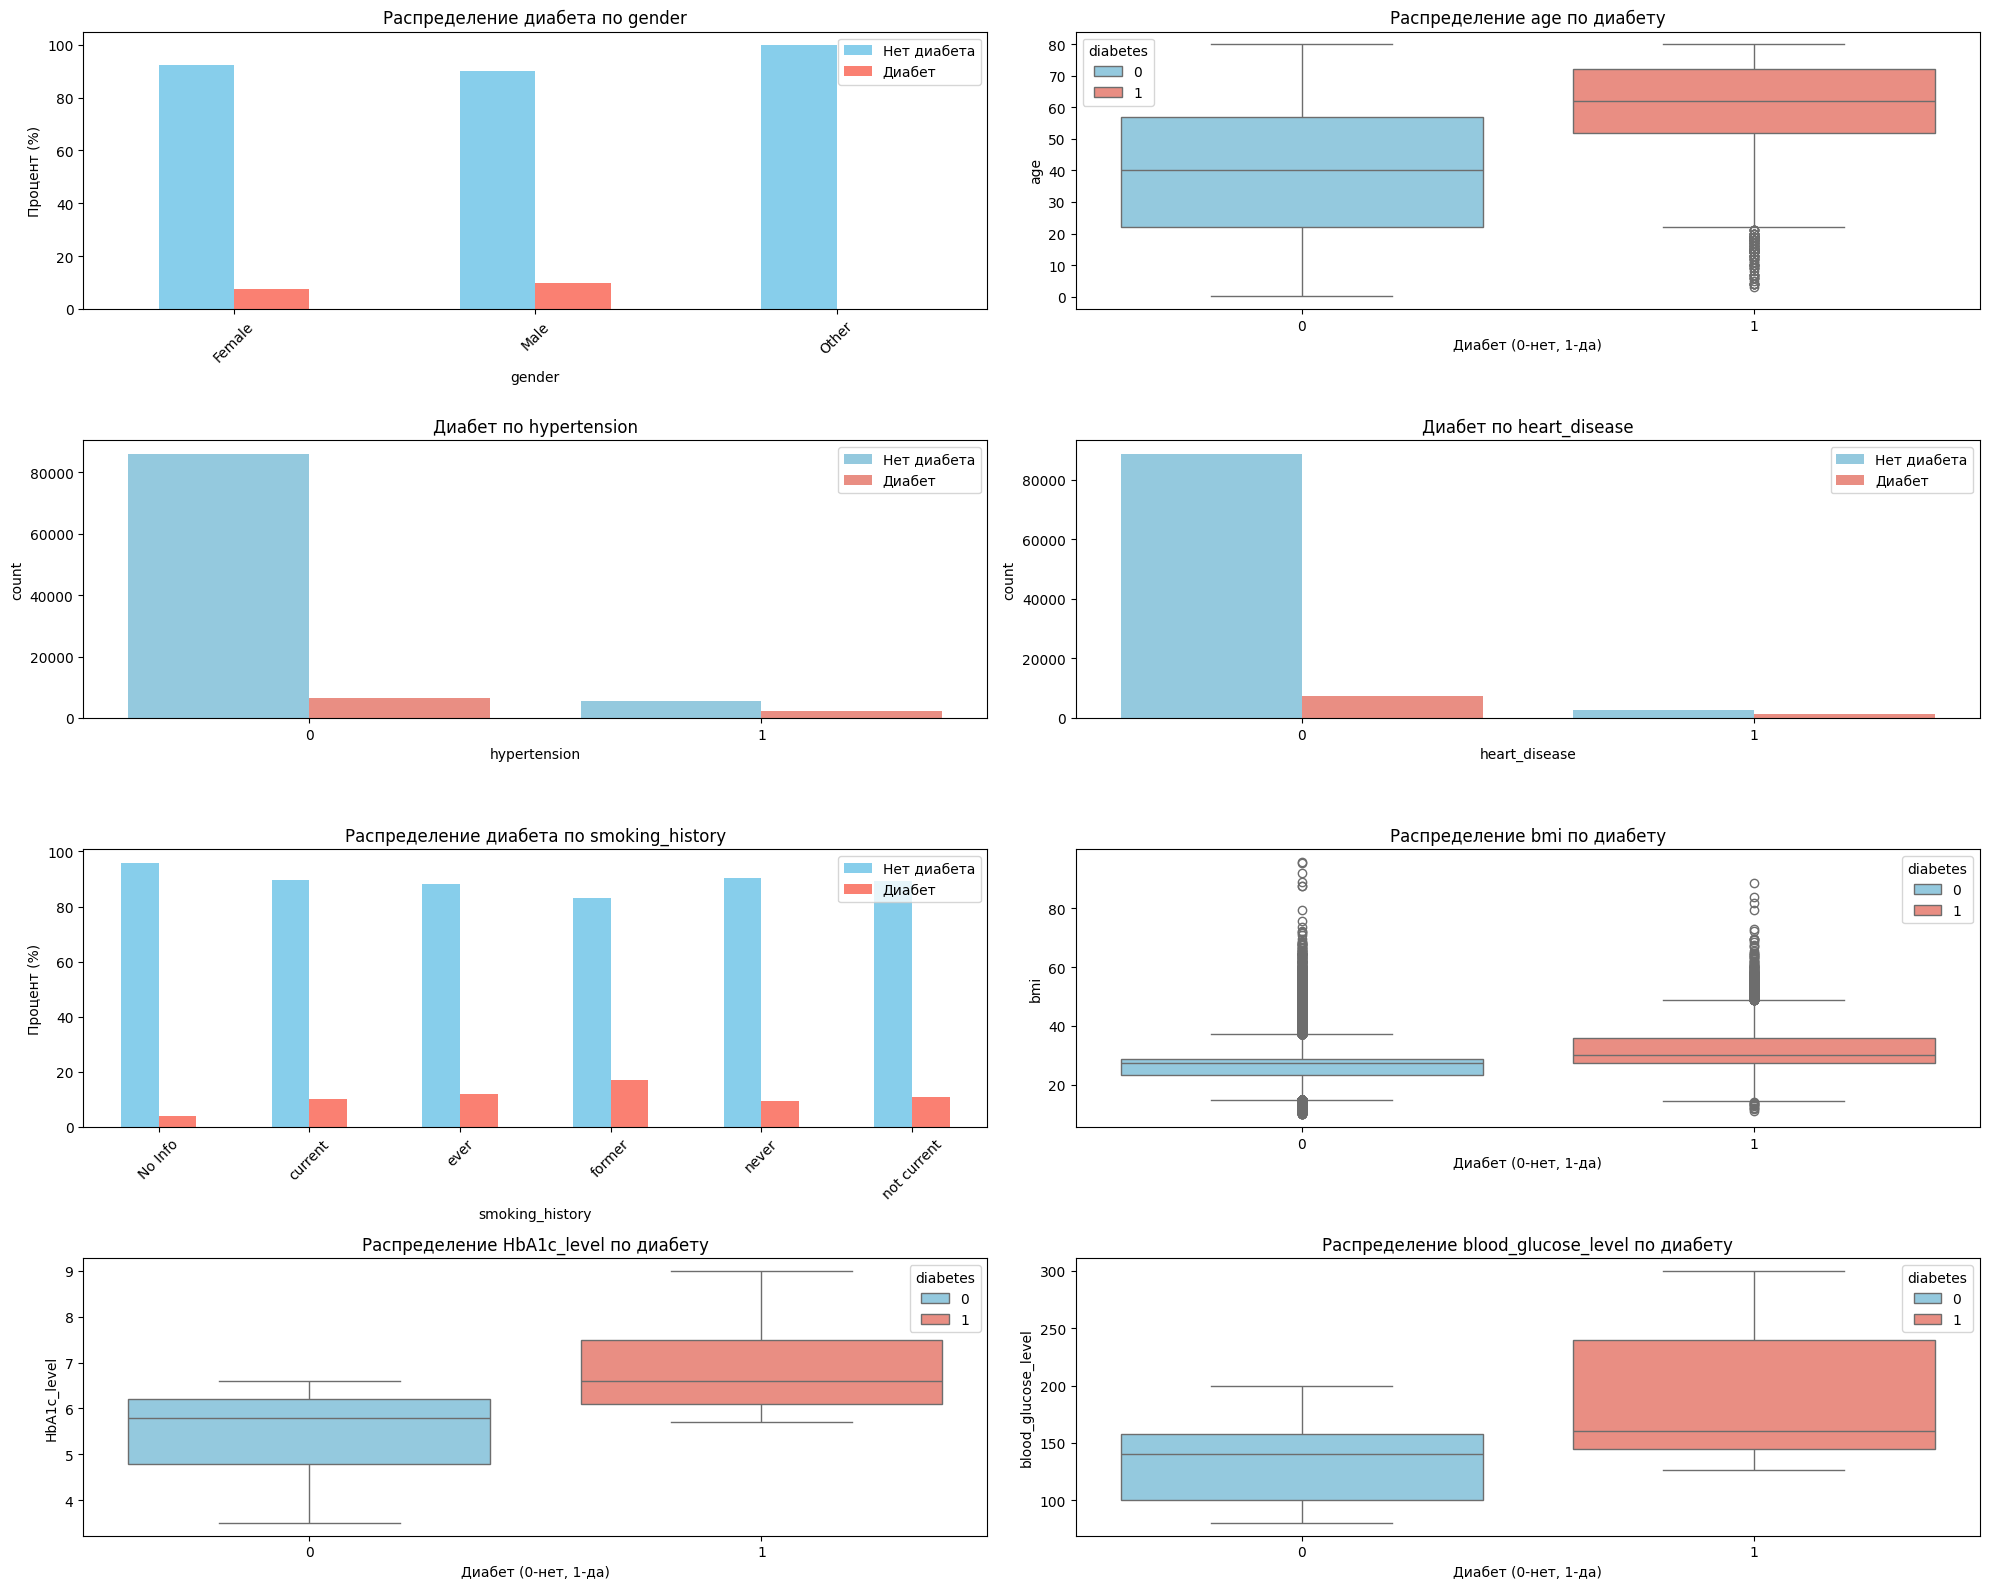

In [15]:
fig = plt.figure(figsize=(20, 16))

all_features = ['gender', 'age', 'hypertension', 'heart_disease', 
                'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']

for i, feature in enumerate(all_features, 1):
    plt.subplot(4, 2, i)
    
    if feature in ['gender', 'smoking_history']:  # Категориальные признаки
        cross_tab = pd.crosstab(diabetes_df[feature], diabetes_df['diabetes'], normalize='index') * 100
        cross_tab.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'salmon'])
        plt.title(f'Распределение диабета по {feature}')
        plt.ylabel('Процент (%)')
        plt.legend(['Нет диабета', 'Диабет'])
        plt.xticks(rotation=45)
        
    elif feature in ['hypertension', 'heart_disease']:  # Бинарные признаки
        sns.countplot(data=diabetes_df, x=feature, hue='diabetes', palette=['skyblue', 'salmon'])
        plt.title(f'Диабет по {feature}')
        plt.legend(['Нет диабета', 'Диабет'])
        
    else:  # Числовые признаки
        sns.boxplot(data=diabetes_df, x='diabetes', y=feature, palette=['skyblue', 'salmon'], hue='diabetes')
        plt.title(f'Распределение {feature} по диабету')
        plt.xlabel('Диабет (0-нет, 1-да)')

plt.tight_layout()
plt.show()

Из графика рапределения bmi явно видны выбросы. Их необходимо будет почистить

In [16]:
def remove_outliers_iqr_by_group(df, column, group_column):
    df_clean = df.copy()
    for group in df[group_column].unique():
        group_data = df[df[group_column] == group]
        Q1 = group_data[column].quantile(0.25)
        Q3 = group_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_mask = (df_clean[group_column] == group) & (
            (df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)
        )
        df_clean = df_clean[~outliers_mask]
    return df_clean

diabetes_clean = remove_outliers_iqr_by_group(diabetes_df, 'bmi', 'diabetes')
diabetes_clean.shape, diabetes_df.shape

((92935, 9), (100000, 9))

Посмотрим как прошли изменения

Text(0.5, 0, 'Диабет (0-нет, 1-да)')

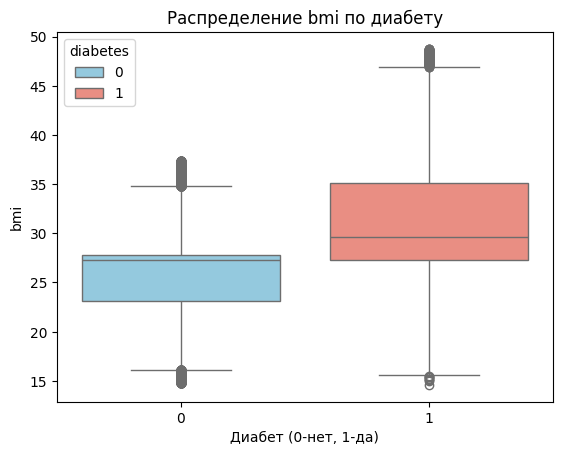

In [17]:
sns.boxplot(data=diabetes_clean, x='diabetes', y='bmi', palette=['skyblue', 'salmon'], hue='diabetes')
plt.title('Распределение bmi по диабету')
plt.xlabel('Диабет (0-нет, 1-да)')

Построим матрицу корреляции

<Figure size 1000x800 with 0 Axes>

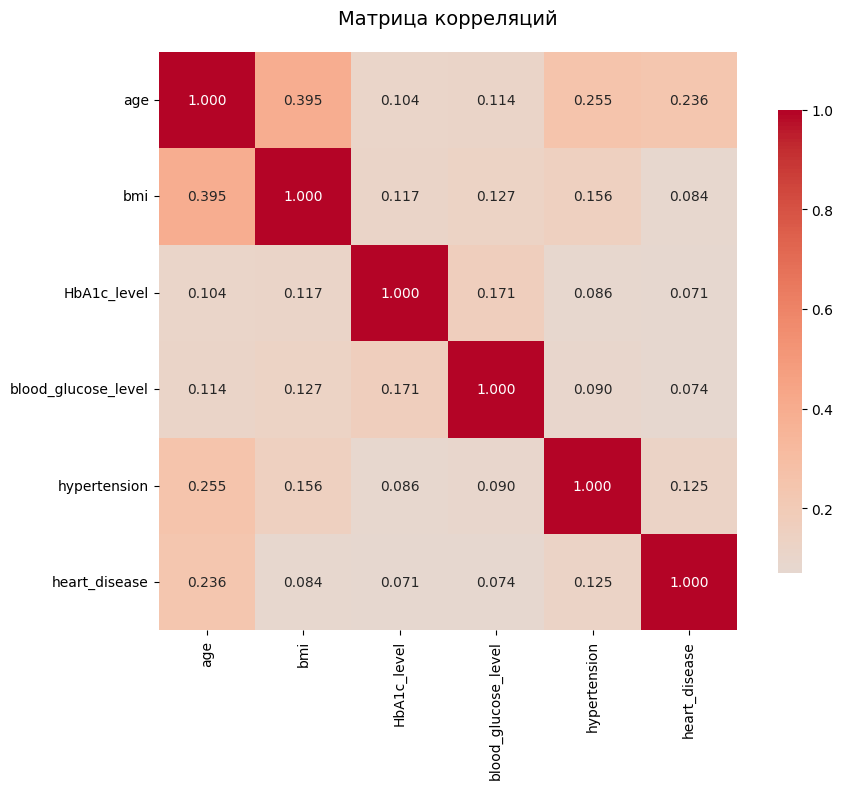

In [18]:
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
binary_features = ['hypertension', 'heart_disease']

plt.figure(figsize=(10, 8))
corr_matrix = diabetes_clean[numeric_features + binary_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Построим графику зависимости между числовыми признаками

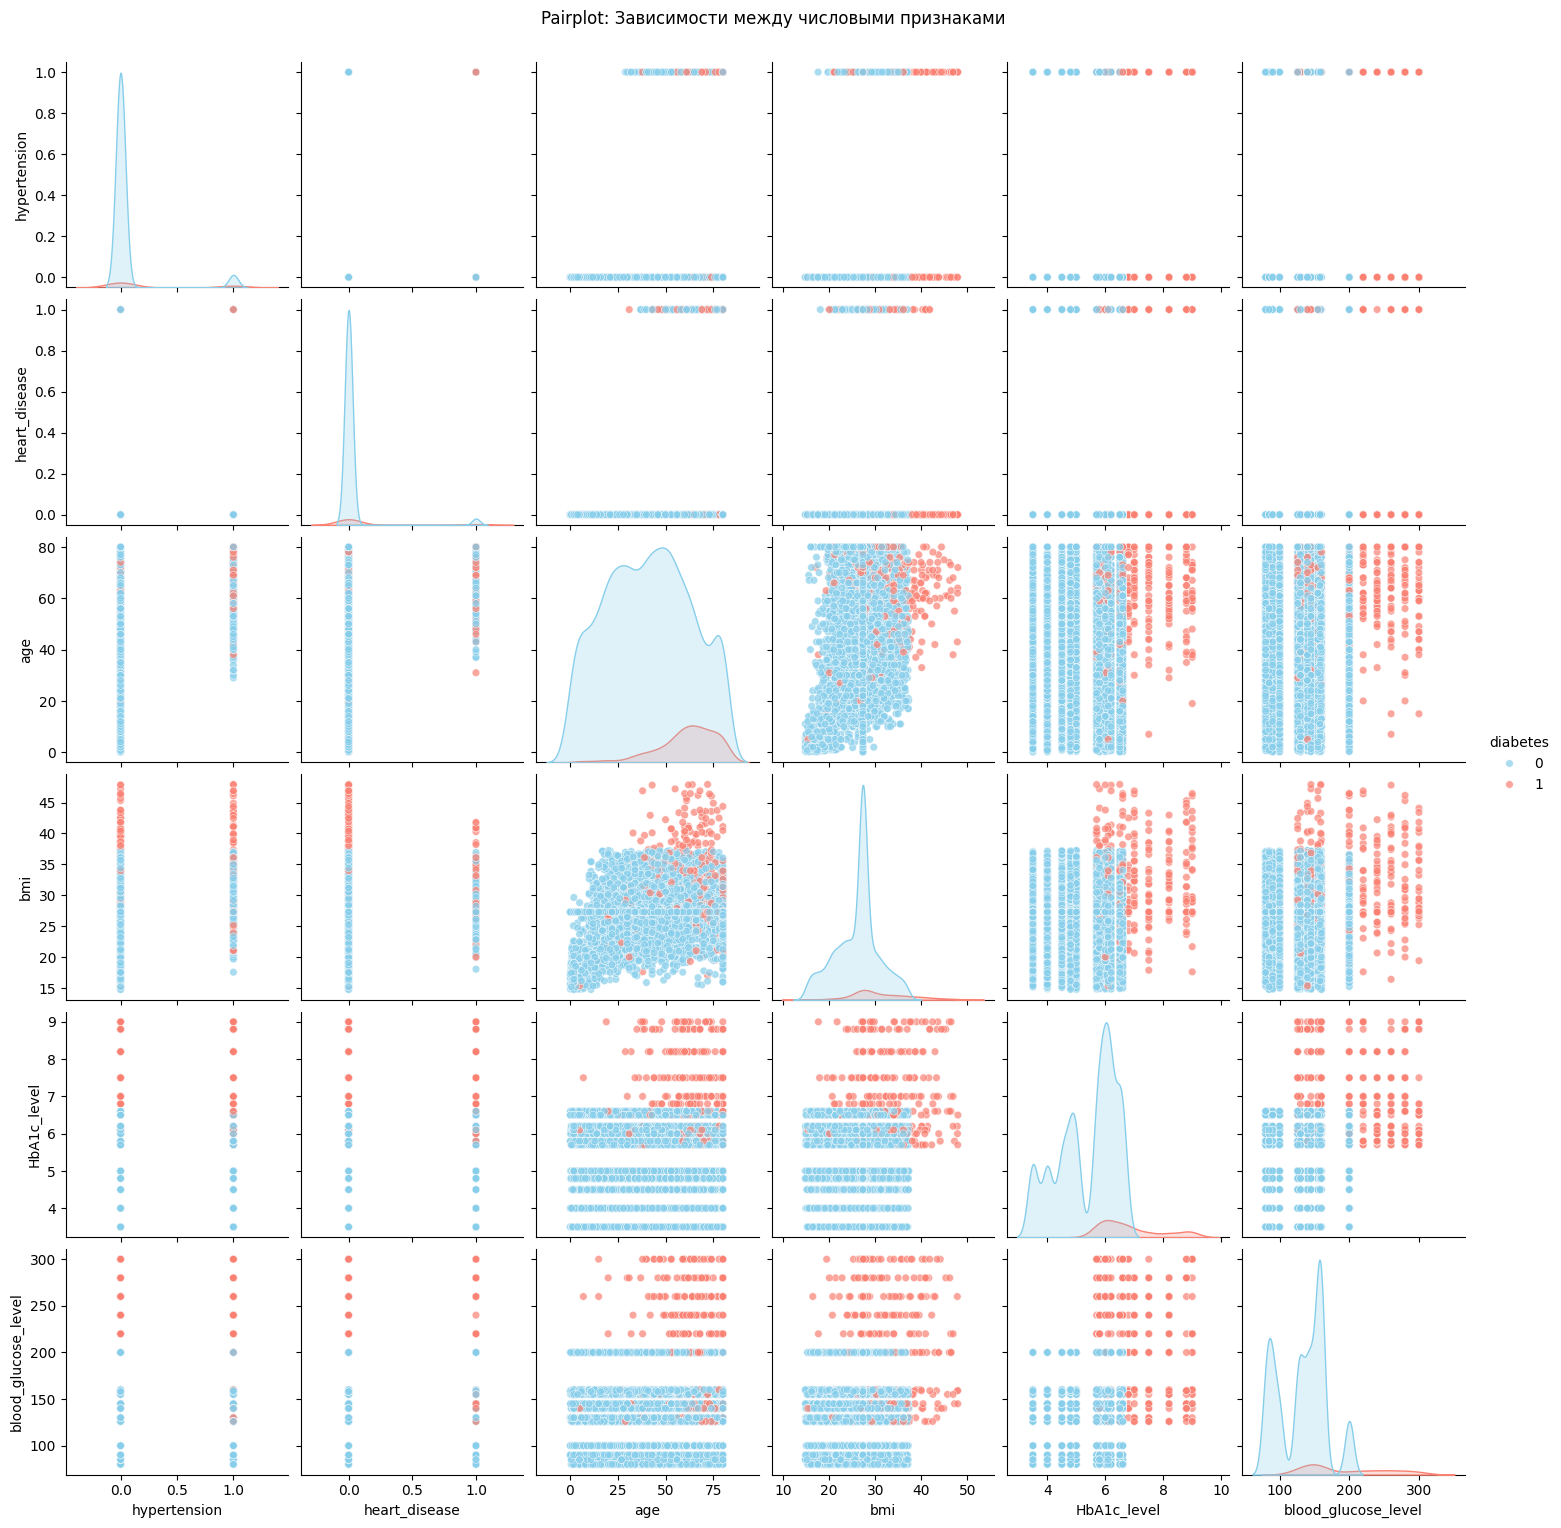

In [19]:
sns.pairplot(diabetes_clean[binary_features + numeric_features + ['diabetes']].sample(n=5000, random_state=42),
             hue='diabetes', palette=['skyblue', 'salmon'],
             diag_kind='kde', plot_kws={'alpha': 0.7, 's': 30})
plt.suptitle('Pairplot: Зависимости между числовыми признаками', y=1.02)
plt.show()

Создадим новые фичи на основе числовых

In [20]:
def create_num_features(df):
    new_df = df.copy()
    
    new_df['log(age*bmi*HbA1c_level*blood_glucose_level+1)'] = np.log(new_df['age'] * new_df['bmi'] * new_df['HbA1c_level'] * new_df['blood_glucose_level'] + 1)

    new_df['age*bmi'] = new_df['age'] * new_df['bmi']
    new_df['HbA1c_levelxblood_glucose_level'] = new_df['HbA1c_level'] * new_df['blood_glucose_level']
    new_df['bmi*blood_glucose_level'] = new_df['bmi'] * new_df['blood_glucose_level']

    new_df['bmi*HbA1c_level*blood_glucose_level'] = new_df['bmi'] * new_df['HbA1c_level'] * new_df['blood_glucose_level']

    new_df['bmi/age'] = new_df['bmi'] / (new_df['age'] + 1e-6)
    new_df['blood_glucose_level/HbA1c_level'] = new_df['blood_glucose_level'] / (new_df['HbA1c_level'] + 1e-6)
    new_df['blood_glucose_level/age'] = new_df['blood_glucose_level'] / new_df['age']


    new_df['bmi^2'] = new_df['bmi'] ** 2
    new_df['HbA1c_level^2'] = new_df['HbA1c_level'] ** 2
    new_df['blood_glucose_level^2'] = new_df['blood_glucose_level'] ** 2

    new_df['log_blood_glucose_level+1'] = np.log(new_df['blood_glucose_level'] + 1)
    new_df['log_HbA1c_level+1'] = np.log(new_df['HbA1c_level'] + 1)
    new_df['log_bmi+1'] = np.log(new_df['bmi'] + 1)

    new_df['age_z'] = (new_df['age'] - new_df['age'].mean()) / new_df['age'].std()
    new_df['bmi_z'] = (new_df['bmi'] - new_df['bmi'].mean()) / new_df['bmi'].std()
    new_df['HbA1c_level_z'] = (new_df['HbA1c_level'] - new_df['HbA1c_level'].mean()) / new_df['HbA1c_level'].std()
    new_df['blood_glucose_level_z'] = (new_df['blood_glucose_level'] - new_df['blood_glucose_level'].mean()) / new_df['blood_glucose_level'].std()

    new_df['risk_index'] = (new_df['age_z'] + new_df['bmi_z'] + new_df['HbA1c_level_z'] + new_df['blood_glucose_level_z']) / 4
    
    return new_df


Теперь поработаем с историей курения

In [21]:
print(diabetes_clean['smoking_history'].value_counts())

smoking_history
No Info        33574
never          32436
current         8628
former          8596
not current     6012
ever            3689
Name: count, dtype: int64


"No Info" - Информация отсутствует (пропущенные данные)

"never" - Никогда не курил

"former" - Бывший курильщик

"current" - Текущий курильщик

"not current" - В настоящее время не курит (похоже на "former")

"ever" - Когда-либо курил (похоже на "former")


Поэтому закодирую следующим образом

In [22]:
def create_smoking_features(df):
    new_df = df.copy()
    mapping = {
        'No Info': np.nan,
        'never': 0,
        'former': 1,
        'current': 2,
        'not current': 1,
        'ever': 1
    }

    new_df['smoking_history_encoded'] = (
        new_df['smoking_history']
        .map(mapping)
        .fillna(new_df['smoking_history'].map(mapping).mean())
    )
    new_df = new_df.drop('smoking_history', axis=1)
    return new_df

Также сделаем обработку gender

In [23]:
print(diabetes_clean['gender'].value_counts())

gender
Female    53779
Male      39140
Other        16
Name: count, dtype: int64


Other заменим на среднее значение и сделаем новый признак

In [24]:
def create_gender_features(df):
    new_df = df.copy()
    mapping = {
        'Other': np.nan,
        'Male': 1,
        'Female': 0
    }

    new_df['gender_encoded'] = (
        df['gender']
        .map(mapping)
        .fillna(df['gender'].map(mapping).mean())
    )
    
    new_df = new_df.drop('gender', axis=1)
    return new_df

Добавим еще несколько бинарных признаков

In [25]:
def create_binary_features(df):
    new_df = df.copy()
    new_df['hypertension*glucose'] = new_df['hypertension'] * new_df['blood_glucose_level']
    new_df['heart_disease*HbA1c_level'] = new_df['heart_disease'] * new_df['HbA1c_level']
    new_df['overweighted'] = (new_df['bmi'] > 25).astype(int)
    new_df['obese'] = (new_df['bmi'] > 30).astype(int)
    new_df['young'] = (new_df['age'] < 30).astype(int)
    new_df['elder'] = (new_df['age'] >= 60).astype(int)
    return new_df

Медицинские показатели

In [26]:
def create_medical_features(df):
    new_df = df.copy()
    new_df['metabolic_syndrome'] = (new_df['bmi'] > 30).astype(int) + new_df['hypertension'] + new_df['heart_disease']
    new_df['heart_diseaseORhypertension'] = (new_df['heart_disease'] | new_df['hypertension']).astype(int)
    new_df['high_HbA1c_level'] = (new_df['HbA1c_level'] > 6).astype(int)
    new_df['high_blood_glucose_level'] = (new_df['blood_glucose_level'] > 125).astype(int)
    new_df['normal_blood_glucose_level'] = (new_df['blood_glucose_level'] < 100).astype(int)
    return new_df

Создать все features

In [27]:
def create_features(df):
    new_df = df.copy()
    new_df = create_num_features(new_df)
    new_df = create_smoking_features(new_df)
    new_df = create_gender_features(new_df)
    new_df = create_binary_features(new_df)
    new_df = create_medical_features(new_df)
    return new_df

diabetes_new_features = create_features(diabetes_clean)
diabetes_new_features.columns

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes',
       'log(age*bmi*HbA1c_level*blood_glucose_level+1)', 'age*bmi',
       'HbA1c_levelxblood_glucose_level', 'bmi*blood_glucose_level',
       'bmi*HbA1c_level*blood_glucose_level', 'bmi/age',
       'blood_glucose_level/HbA1c_level', 'blood_glucose_level/age', 'bmi^2',
       'HbA1c_level^2', 'blood_glucose_level^2', 'log_blood_glucose_level+1',
       'log_HbA1c_level+1', 'log_bmi+1', 'age_z', 'bmi_z', 'HbA1c_level_z',
       'blood_glucose_level_z', 'risk_index', 'smoking_history_encoded',
       'gender_encoded', 'hypertension*glucose', 'heart_disease*HbA1c_level',
       'overweighted', 'obese', 'young', 'elder', 'metabolic_syndrome',
       'heart_diseaseORhypertension', 'high_HbA1c_level',
       'high_blood_glucose_level', 'normal_blood_glucose_level'],
      dtype='object')

Построим матрицу корреляции

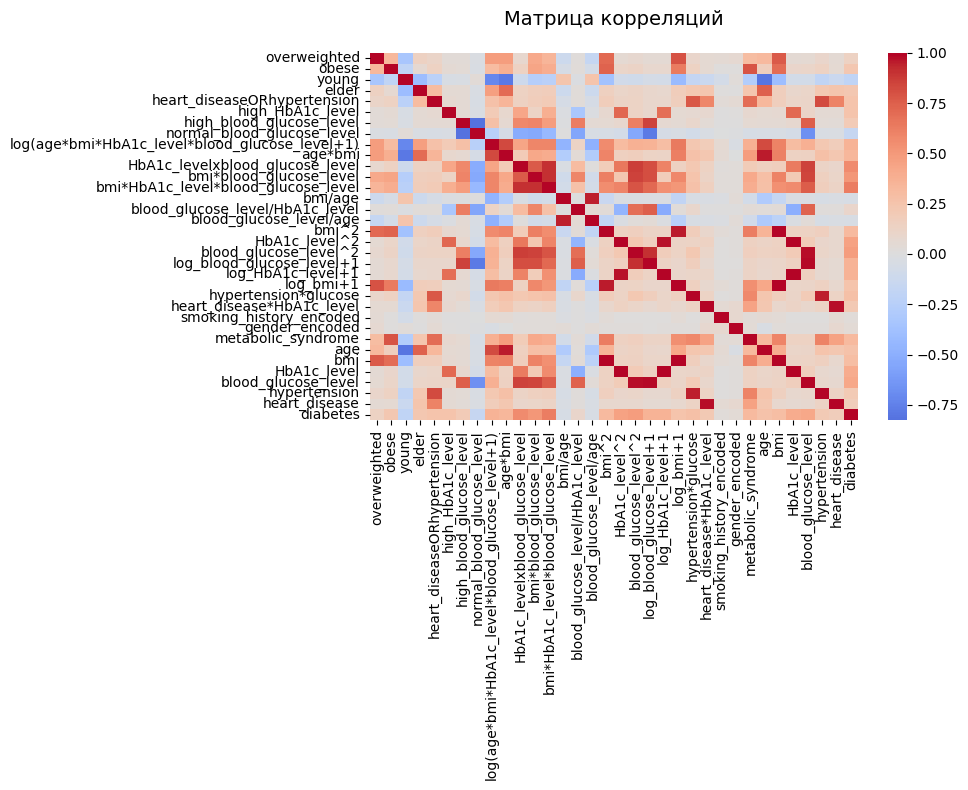

In [28]:
new_features = ['overweighted', 'obese', 'young', 'elder', 'heart_diseaseORhypertension', 'high_HbA1c_level', 'high_blood_glucose_level', 'normal_blood_glucose_level',
                'log(age*bmi*HbA1c_level*blood_glucose_level+1)', 'age*bmi', 'HbA1c_levelxblood_glucose_level', 'bmi*blood_glucose_level', 'bmi*HbA1c_level*blood_glucose_level',
                'bmi/age', 'blood_glucose_level/HbA1c_level', 'blood_glucose_level/age', 'bmi^2', 'HbA1c_level^2', 'blood_glucose_level^2', 'log_blood_glucose_level+1', 'log_HbA1c_level+1', 'log_bmi+1',
                'hypertension*glucose', 'heart_disease*HbA1c_level', 'smoking_history_encoded', 'gender_encoded', 'metabolic_syndrome']

old_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease', 'diabetes']


corr_matrix = diabetes_new_features[new_features + old_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Уменьшим мультиколлинеарность и упростим модель. Для этого удалю числовые признаки, которые имеют высокую корреляцию с другими. Исключу признаки с корреляцией Пирсона выше порогового значения = 0,95.

In [29]:
def drop_highly_correlated_features(df, threshold=0.95):
    df_clean = df.copy()
    corr_matrix = df_clean.corr().abs()
    upper_triangle = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    high_corr_pairs = np.where((corr_matrix > threshold) & upper_triangle)
    to_drop = set()
    for i, j in zip(*high_corr_pairs):
        feature_i = corr_matrix.columns[i]
        feature_j = corr_matrix.columns[j]
        if corr_matrix[feature_i].mean() > corr_matrix[feature_j].mean():
            to_drop.add(feature_j)
        else:
            to_drop.add(feature_i)
    df_clean = df_clean.drop(columns=to_drop)
    return df_clean

diabetes_new_features = drop_highly_correlated_features(diabetes_new_features[new_features + old_features])

Поссмотрим, что сейчас представляет из себя матрица корреляции

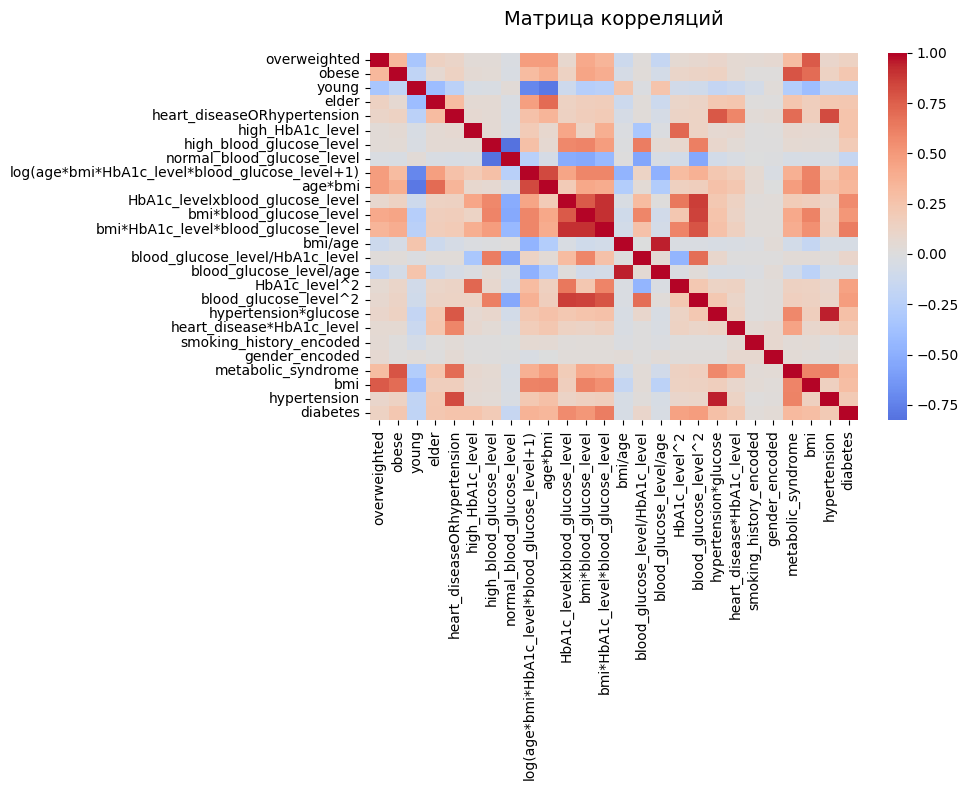

In [30]:
corr_matrix = diabetes_new_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Посмортим на результат после создания новых фич

Для начала снова подготовим данные

In [31]:

# Разделим выборки на train и test,
# Но т.к. нужно удалить выбросы только, для train выборки, то делаем:

from sklearn.preprocessing import RobustScaler

diabetes_X = diabetes_df.drop('diabetes', axis=1)
diabetes_y = diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42,
)

diabetes_train_df = pd.DataFrame(diabetes_X_train, columns=diabetes_X.columns)
diabetes_train_df['diabetes'] = diabetes_y_train

diabetes_test_df = pd.DataFrame(diabetes_X_test, columns=diabetes_X.columns)
diabetes_test_df['diabetes'] = diabetes_y_test

# Удалим выбросы только для train
diabetes_train_df = remove_outliers_iqr_by_group(diabetes_train_df, 'bmi', 'diabetes')

# Создаем фичи
diabetes_train_df = create_features(diabetes_train_df)
diabetes_test_df = create_features(diabetes_test_df)

# Удалим features, которые имеют высокую корреляцию с другими
diabetes_train_df = drop_highly_correlated_features(diabetes_train_df)
diabetes_test_df = diabetes_test_df[diabetes_train_df.columns]

# Снова отделим target от всех остальных данных
diabetes_X_train = diabetes_train_df.drop('diabetes', axis=1)
diabetes_y_train = diabetes_train_df['diabetes']

diabetes_X_test = diabetes_test_df.drop('diabetes', axis=1)
diabetes_y_test = diabetes_test_df['diabetes']

# Применим RobustScaler, т.к. он устойчив к выбросам
scaler = RobustScaler()
diabetes_X_train = pd.DataFrame(scaler.fit_transform(diabetes_X_train), columns=diabetes_X_train.columns)
diabetes_X_test = pd.DataFrame(scaler.transform(diabetes_X_test), columns=diabetes_X_test.columns)

Кросс-валидация и выбор лучшей модели по fbeta-score (beta = 1,2,3)

In [32]:
from sklearn.model_selection import cross_val_score
import optuna

def find_best_hyperparameters_cv(X, y, n_trials=10, cv=5, scoring='accuracy', n_jobs=-1):
    def objective(trial):
        n_neighbors = trial.suggest_int('n_neighbors', 3, 15)
        weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
        p = trial.suggest_int('p', 1, 3)
        metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
        
        model = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            p=p,
            metric=metric,
            n_jobs=n_jobs
        )
        
        return cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params


best_params = {
    'f1' : {'n_neighbors': 7, 'weights': 'uniform', 'p': 2, 'metric': 'manhattan'},
    'f2' : {'n_neighbors': 4, 'weights': 'distance', 'p': 1, 'metric': 'euclidean'},
    'f3' : {'n_neighbors': 3, 'weights': 'distance', 'p': 3, 'metric': 'manhattan'}
}

for beta in [1, 2, 3]:
    scorer = make_scorer(fbeta_score, beta=beta) 
    if not best_params.get(f'f{beta}'):
        best_params[f'f{beta}'] = find_best_hyperparameters_cv(
            diabetes_X_train,
            diabetes_y_train,
            n_trials=10,
            cv=StratifiedKFold(n_splits=5),
            scoring=scorer
        )
    
    print(f"\n=== Best Model f{beta} on validation ===")
    print(f"Best params: {best_params[f'f{beta}']}")



=== Best Model f1 on validation ===
Best params: {'n_neighbors': 7, 'weights': 'uniform', 'p': 2, 'metric': 'manhattan'}

=== Best Model f2 on validation ===
Best params: {'n_neighbors': 4, 'weights': 'distance', 'p': 1, 'metric': 'euclidean'}

=== Best Model f3 on validation ===
Best params: {'n_neighbors': 3, 'weights': 'distance', 'p': 3, 'metric': 'manhattan'}


/home/jonaj/StudyDir/AI_LABS/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Подберем оптимальный threshold для каждой из моделей и каждой из fbeta метрик

In [33]:
optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for beta in [1, 2, 3]:
    for model_name in [1, 2, 3]:
        model = KNeighborsClassifier(**best_params[f'f{model_name}'])
        
        model, threshold, fold_score = find_optimal_threshhold_cv(
            model,
            diabetes_X_train,
            diabetes_y_train,
            cv=5,
            f_beta=beta,
            report=True
        )
        if optimal_models.get(f'f{beta}'):
            if fold_score['f_beta_score'] > optimal_fold_scores[f'f{beta}']['f_beta_score']:
                optimal_models[f'f{beta}'] = model
                optimal_thresholds[f'f{beta}'] = threshold
                optimal_fold_scores[f'f{beta}'] = fold_score
        else:
            optimal_models[f'f{beta}'] = model
            optimal_thresholds[f'f{beta}'] = threshold
            optimal_fold_scores[f'f{beta}'] = fold_score


=== Best Model f1 on validation ===
Best fold: 1
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     13529
           1       0.95      0.67      0.79      1312

    accuracy                           0.97     14841
   macro avg       0.96      0.84      0.89     14841
weighted avg       0.97      0.97      0.97     14841

Best f1-score: 0.7902
Best f2-score: 0.7165
Best f3-score: 0.6949
Best f1-score: 0.7902
Best threshold: 0.5714285714285714

=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     13529
           1       0.86      0.71      0.77      1312

    accuracy                           0.96     14841
   macro avg       0.91      0.85      0.88     14841
weighted avg       0.96      0.96      0.96     14841

Best f1-score: 0.7737
Best f2-score: 0.7310
Best f3-score: 0.7178
Best f1-score: 0.7737
Best threshold: 0.4955699882382833


Посмотрим, что получилось на валидации

In [34]:
for beta in [1, 2, 3]:
    print(optimal_fold_scores[f'f{beta}']['classification_report'])
    print(f"Best f{beta}-score: {optimal_fold_scores[f'f{beta}']['f_beta_score']:.4f}")
    

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     13529
           1       0.95      0.67      0.79      1312

    accuracy                           0.97     14841
   macro avg       0.96      0.84      0.89     14841
weighted avg       0.97      0.97      0.97     14841

Best f1-score: 0.7902
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     13529
           1       0.67      0.80      0.73      1312

    accuracy                           0.95     14841
   macro avg       0.83      0.88      0.85     14841
weighted avg       0.95      0.95      0.95     14841

Best f2-score: 0.7681
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     13529
           1       0.45      0.89      0.60      1312

    accuracy                           0.89     14841
   macro avg       0.72      0.89      0.77     14841
weighted avg       0.94      0

Проведем замеры на тестовой выборке

In [35]:
for beta in [1, 2, 3]:
    model = optimal_models[f'f{beta}']
    threshold = optimal_thresholds[f'f{beta}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{beta} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{beta}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=beta):.4f}")
    print(f"threshold: {threshold}")


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.81      0.66      0.73      1700

    accuracy                           0.96     20000
   macro avg       0.89      0.82      0.85     20000
weighted avg       0.96      0.96      0.96     20000

f1-score: 0.7286
f2-score: 0.6858
f3-score: 0.6727
f1-score: 0.7286
threshold: 0.5714285714285714

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     18300
           1       0.60      0.79      0.68      1700

    accuracy                           0.94     20000
   macro avg       0.79      0.87      0.82     20000
weighted avg       0.95      0.94      0.94     20000

f1-score: 0.6799
f2-score: 0.7394
f3-score: 0.7617
f2-score: 0.7394
threshold: 0.2857142857142857

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.99   

Вывод: улучшения повысили детекцию класса 1 (есть диабет), особенно recall. Лучший баланс между precision и recall показывает модель, где оптимизировалась метрика f1. Однако если нам нужно найти всех реально больных, то лучше использовать модель, где оптимизировалась метрика f2

### 4.  Имплементация алгоритма машинного обучения 

4.1. Задача классификации

In [36]:
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import BallTree, KDTree


class LabKNeighborsClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, weights='uniform', 
                 p=2, metric='minkowski', n_jobs=None, 
                 leaf_size=30, algorithm='auto'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.p = p
        self.metric = metric
        self.n_jobs = n_jobs
        self.leaf_size = leaf_size
        self.algorithm = algorithm
        
        self.kd_tree_metrics = {
            'euclidean', 'manhattan', 'chebyshev', 'minkowski',
            'cityblock', 'l1', 'l2', 'infinity'
        }
        
        self.ball_tree_metrics = {
            'cosine', 'haversine', 'hamming', 
            'jaccard', 'dice', 'matching',
            'mahalanobis', 'seuclidean', 'wminkowski'
        }
        
        self.brute_only_metrics = {
            'canberra', 'braycurtis', 'correlation', 'sqeuclidean',
            'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener',
            'sokalsneath', 'yule'
        }
    
    def _select_algorithm(self):
        if self.algorithm != 'auto':
            return self.algorithm
            
        if self.metric in self.brute_only_metrics:
            return 'brute'
            
        if self.metric in self.kd_tree_metrics:
            if self.metric == 'minkowski':
                if self.p == 1 or self.p == 2 or self.p == np.inf:
                    return 'kd_tree'
                else:
                    return 'ball_tree'
            return 'kd_tree'
        elif self.metric in self.ball_tree_metrics:
            return 'ball_tree'
        else:
            return 'brute'
    
    def _compute_distance(self, x1, x2):
        if self.metric == 'euclidean' or self.metric == 'l2':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan' or self.metric == 'cityblock' or self.metric == 'l1':
            return np.sum(np.abs(x1 - x2))
        elif self.metric == 'chebyshev' or self.metric == 'infinity':
            return np.max(np.abs(x1 - x2))
        elif self.metric == 'minkowski':
            return np.power(np.sum(np.power(np.abs(x1 - x2), self.p)), 1/self.p)
        elif self.metric == 'cosine':
            dot_product = np.dot(x1, x2)
            norm1 = np.linalg.norm(x1)
            norm2 = np.linalg.norm(x2)
            return 1 - dot_product / (norm1 * norm2 + 1e-10)
        elif self.metric == 'hamming':
            return np.mean(x1 != x2)
        elif self.metric == 'sqeuclidean':
            return np.sum((x1 - x2) ** 2)
        elif self.metric == 'canberra':
            numerator = np.abs(x1 - x2)
            denominator = np.abs(x1) + np.abs(x2)
            return np.sum(np.divide(numerator, denominator, 
                                   out=np.zeros_like(numerator), 
                                   where=denominator!=0))
        elif self.metric == 'braycurtis':
            return np.sum(np.abs(x1 - x2)) / np.sum(np.abs(x1 + x2))
        else:
            return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def _brute_neighbors(self, X_query, n_neighbors=None):
        if n_neighbors is None:
            n_neighbors = self.n_neighbors
        
        n_query = X_query.shape[0]
        n_train = self.X_.shape[0]
        
        distances = np.zeros((n_query, n_train))
        
        for i in range(n_query):
            if self.metric == 'euclidean' or self.metric == 'l2':
                distances[i, :] = np.sqrt(np.sum((self.X_ - X_query[i]) ** 2, axis=1))
            elif self.metric == 'manhattan' or self.metric == 'cityblock' or self.metric == 'l1':
                distances[i, :] = np.sum(np.abs(self.X_ - X_query[i]), axis=1)
            elif self.metric == 'chebyshev' or self.metric == 'infinity':
                distances[i, :] = np.max(np.abs(self.X_ - X_query[i]), axis=1)
            elif self.metric == 'minkowski':
                distances[i, :] = np.power(
                    np.sum(np.power(np.abs(self.X_ - X_query[i]), self.p), axis=1),
                    1/self.p
                )
            elif self.metric == 'cosine':
                dot_products = np.dot(self.X_, X_query[i])
                norms_X = np.linalg.norm(self.X_, axis=1)
                norm_query = np.linalg.norm(X_query[i])
                distances[i, :] = 1 - dot_products / (norms_X * norm_query + 1e-10)
            elif self.metric == 'sqeuclidean':
                distances[i, :] = np.sum((self.X_ - X_query[i]) ** 2, axis=1)
            else:
                for j in range(n_train):
                    distances[i, j] = self._compute_distance(X_query[i], self.X_[j])
        
        if n_neighbors == 1:
            indices = np.argmin(distances, axis=1).reshape(-1, 1)
            neighbor_distances = np.min(distances, axis=1).reshape(-1, 1)
        else:
            partition_indices = np.argpartition(distances, n_neighbors, axis=1)[:, :n_neighbors]

            indices = np.zeros((n_query, n_neighbors), dtype=int)
            neighbor_distances = np.zeros((n_query, n_neighbors))
            
            for i in range(n_query):
                k_distances = distances[i, partition_indices[i]]
                
                sorted_k_indices = np.argsort(k_distances)
                
                indices[i] = partition_indices[i][sorted_k_indices]
                neighbor_distances[i] = k_distances[sorted_k_indices]
        
        return neighbor_distances, indices
    
    def _build_tree(self, X):
        selected_algorithm = self._select_algorithm()
        
        if selected_algorithm == 'kd_tree':
            try:
                if self.metric == 'manhattan' or self.metric == 'l1':
                    metric_name = 'cityblock'
                    tree_kwargs = {'p': 1} if self.metric == 'minkowski' else {}
                elif self.metric == 'euclidean' or self.metric == 'l2':
                    metric_name = 'euclidean'
                    tree_kwargs = {'p': 2} if self.metric == 'minkowski' else {}
                elif self.metric == 'chebyshev' or self.metric == 'infinity':
                    metric_name = 'chebyshev'
                    tree_kwargs = {}
                elif self.metric == 'minkowski':
                    metric_name = 'minkowski'
                    tree_kwargs = {'p': self.p}
                else:
                    metric_name = self.metric
                    tree_kwargs = {}
                
                if tree_kwargs:
                    self.tree_ = KDTree(X, leaf_size=self.leaf_size, 
                                       metric=metric_name, **tree_kwargs)
                else:
                    self.tree_ = KDTree(X, leaf_size=self.leaf_size, 
                                       metric=metric_name)
                    
                self.tree_type_ = 'kd_tree'
                
            except (ValueError, TypeError) as e:
                print(f"KDTree не поддерживает метрику {self.metric} с параметрами: {e}")
                print("Пробуем BallTree...")
                selected_algorithm = 'ball_tree'
        
        if selected_algorithm == 'ball_tree' or (selected_algorithm == 'kd_tree' and not hasattr(self, 'tree_')):
            try:
                if self.metric == 'manhattan' or self.metric == 'l1':
                    metric_name = 'cityblock'
                    tree_kwargs = {'p': 1} if self.metric == 'minkowski' else {}
                elif self.metric == 'euclidean' or self.metric == 'l2':
                    metric_name = 'euclidean'
                    tree_kwargs = {'p': 2} if self.metric == 'minkowski' else {}
                elif self.metric == 'chebyshev' or self.metric == 'infinity':
                    metric_name = 'chebyshev'
                    tree_kwargs = {}
                elif self.metric == 'minkowski':
                    metric_name = 'minkowski'
                    tree_kwargs = {'p': self.p}
                else:
                    metric_name = self.metric
                    tree_kwargs = {}
                
                if tree_kwargs:
                    self.tree_ = BallTree(X, leaf_size=self.leaf_size, 
                                         metric=metric_name, **tree_kwargs)
                else:
                    self.tree_ = BallTree(X, leaf_size=self.leaf_size, 
                                         metric=metric_name)
                    
                self.tree_type_ = 'ball_tree'
                
            except (ValueError, TypeError) as e:
                print(f"BallTree не поддерживает метрику {self.metric}: {e}")
                print("Используем brute force...")
                self.tree_ = None
                self.tree_type_ = 'brute'
                
        elif selected_algorithm == 'brute' or not hasattr(self, 'tree_'):
            self.tree_ = None
            self.tree_type_ = 'brute'
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        
        self.X_ = X
        self.y_ = y
        self.classes_ = unique_labels(y)
        self.n_classes_ = len(self.classes_)
        
        self._build_tree(X)
        
        return self
    
    def kneighbors(self, X, n_neighbors=None, return_distance=True):
        check_is_fitted(self, ['X_', 'y_', 'tree_type_'])
        X = check_array(X)
        
        if n_neighbors is None:
            n_neighbors = self.n_neighbors
        elif n_neighbors <= 0:
            raise ValueError("n_neighbors должен быть положительным числом")
        
        if n_neighbors > len(self.X_):
            raise ValueError(
                f"n_neighbors ({n_neighbors}) не может быть больше "
                f"количества обучающих образцов ({len(self.X_)})"
            )
        
        if self.tree_type_ in ['kd_tree', 'ball_tree'] and self.tree_ is not None:
            try:
                distances, indices = self.tree_.query(
                    X, 
                    k=n_neighbors,
                    return_distance=return_distance
                )
                if n_neighbors == 1:
                    distances = distances.reshape(-1, 1)
                    indices = indices.reshape(-1, 1)
            except Exception as e:
                print(f"Ошибка при поиске соседей с деревом: {e}")
                print("Переключаюсь на brute force...")
                distances, indices = self._brute_neighbors(X, n_neighbors)
        else: 
            distances, indices = self._brute_neighbors(X, n_neighbors)
        
        if return_distance:
            return distances, indices
        return indices
    
    def predict(self, X):
        check_is_fitted(self, ['X_', 'y_'])
        X = check_array(X)
        
        distances, indices = self.kneighbors(X, return_distance=True)
        
        predictions = []
        for i in range(len(X)):
            neighbor_indices = indices[i]
            neighbor_distances = distances[i]
            neighbor_labels = self.y_[neighbor_indices]
            
            if self.weights == 'uniform':
                votes = Counter(neighbor_labels)
                pred = votes.most_common(1)[0][0]
                
            elif self.weights == 'distance':
                weights_dict = {}
                
                zero_distance_mask = neighbor_distances == 0
                if np.any(zero_distance_mask):
                    zero_indices = np.where(zero_distance_mask)[0]
                    pred = neighbor_labels[zero_indices[0]]
                else:
                    for dist, label in zip(neighbor_distances, neighbor_labels):
                        weight = 1.0 / (dist + 1e-10) 
                        weights_dict[label] = weights_dict.get(label, 0) + weight
                    
                    pred = max(weights_dict.items(), key=lambda x: x[1])[0]
                    
            else:
                raise ValueError(f"Неизвестный метод взвешивания: {self.weights}")
            
            predictions.append(pred)
        
        return np.array(predictions)
    
    def predict_proba(self, X):
        check_is_fitted(self, ['X_', 'y_'])
        X = check_array(X)
        
        distances, indices = self.kneighbors(X, return_distance=True)
        
        n_samples = len(X)
        proba = np.zeros((n_samples, self.n_classes_))
        
        for i in range(n_samples):
            neighbor_indices = indices[i]
            neighbor_distances = distances[i]
            neighbor_labels = self.y_[neighbor_indices]
            
            if self.weights == 'uniform':
                votes = Counter(neighbor_labels)
                for label, count in votes.items():
                    idx = np.where(self.classes_ == label)[0][0]
                    proba[i, idx] = count / len(neighbor_labels)
                    
            elif self.weights == 'distance':
                total_weight = 0
                weights_dict = {}
                
                zero_distance_mask = neighbor_distances == 0
                if np.any(zero_distance_mask):
                    zero_indices = np.where(zero_distance_mask)[0]
                    label = neighbor_labels[zero_indices[0]]
                    idx = np.where(self.classes_ == label)[0][0]
                    proba[i, idx] = 1.0
                    continue
                
                for dist, label in zip(neighbor_distances, neighbor_labels):
                    weight = 1.0 / (dist + 1e-10)
                    weights_dict[label] = weights_dict.get(label, 0) + weight
                    total_weight += weight
                
                if total_weight > 0:
                    for label, weight in weights_dict.items():
                        idx = np.where(self.classes_ == label)[0][0]
                        proba[i, idx] = weight / total_weight
        
        return proba
    
    def score(self, X, y):
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

Проверим работоспособность этого класса

Повторим все действия снова

Сначала с простым бейзлайном

In [37]:
gender_dummies = pd.get_dummies(diabetes_df['gender'], drop_first=True)
smoking_history_dummies = pd.get_dummies(diabetes_df['smoking_history'], drop_first=True)
onehot_diabetes_df = pd.concat([diabetes_df, gender_dummies, smoking_history_dummies], axis=1)

onehot_diabetes_df.drop(['gender', 'smoking_history'], axis=1, inplace=True)
diabetes_X = onehot_diabetes_df.drop('diabetes', axis=1)
diabetes_y = onehot_diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42
)

In [38]:
model = LabKNeighborsClassifier()

optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for beta in [1, 2, 3]:
    optimal_models[f'f{beta}'], optimal_thresholds[f'f{beta}'], optimal_fold_scores[f'f{beta}'] = find_optimal_threshhold_cv(
        model,
        diabetes_X_train,
        diabetes_y_train,
        cv=5,
        f_beta=beta,
        report=True
    )


=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     14640
           1       0.70      0.65      0.67      1360

    accuracy                           0.95     16000
   macro avg       0.83      0.81      0.82     16000
weighted avg       0.94      0.95      0.95     16000

Best f1-score: 0.6725
Best f2-score: 0.6579
Best f3-score: 0.6532
Best f1-score: 0.6725
Best threshold: 0.4

=== Best Model f2 on validation ===
Best fold: 2
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     14640
           1       0.43      0.82      0.56      1360

    accuracy                           0.89     16000
   macro avg       0.71      0.86      0.75     16000
weighted avg       0.93      0.89      0.91     16000

Best f1-score: 0.5648
Best f2-score: 0.6938
Best f3-score: 0.7510
Best f2-score: 0.6938
Best threshold: 0.2

=== Best Model f3 on validati

Проведем замеры на тестовой выборке

In [39]:
for f_score in [1, 2, 3]:
    model = optimal_models[f'f{f_score}']
    threshold = optimal_thresholds[f'f{f_score}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{f_score} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{f_score}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=f_score):.4f}") 


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     18300
           1       0.67      0.64      0.65      1700

    accuracy                           0.94     20000
   macro avg       0.82      0.81      0.81     20000
weighted avg       0.94      0.94      0.94     20000

f1-score: 0.6547
f2-score: 0.6483
f3-score: 0.6462
f1-score: 0.6547

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     18300
           1       0.41      0.80      0.54      1700

    accuracy                           0.88     20000
   macro avg       0.69      0.85      0.74     20000
weighted avg       0.93      0.88      0.90     20000

f1-score: 0.5412
f2-score: 0.6723
f3-score: 0.7313
f2-score: 0.6723

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     18300
           1       0.41      0.8

Вывод: результат оказался таким же как и в KNeighborsClassifier из sklearn

Теперь улучшим бейзлайн

In [40]:
diabetes_X = diabetes_df.drop('diabetes', axis=1)
diabetes_y = diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42
)

diabetes_train_df = pd.DataFrame(diabetes_X_train, columns=diabetes_X.columns)
diabetes_train_df['diabetes'] = diabetes_y_train

diabetes_test_df = pd.DataFrame(diabetes_X_test, columns=diabetes_X.columns)
diabetes_test_df['diabetes'] = diabetes_y_test

# Удалим выбросы только для train
diabetes_train_df = remove_outliers_iqr_by_group(diabetes_train_df, 'bmi', 'diabetes')

# Создаем фичи
diabetes_train_df = create_features(diabetes_train_df)
diabetes_test_df = create_features(diabetes_test_df)

# Удалим features, которые имеют высокую корреляцию с другими
diabetes_train_df = drop_highly_correlated_features(diabetes_train_df)
diabetes_test_df = diabetes_test_df[diabetes_train_df.columns]

# Снова отделим target от всех остальных данных
diabetes_X_train = diabetes_train_df.drop('diabetes', axis=1)
diabetes_y_train = diabetes_train_df['diabetes']

diabetes_X_test = diabetes_test_df.drop('diabetes', axis=1)
diabetes_y_test = diabetes_test_df['diabetes']

# Применим RobustScaler, т.к. он устойчив к выбросам
scaler = RobustScaler()
diabetes_X_train = pd.DataFrame(scaler.fit_transform(diabetes_X_train), columns=diabetes_X_train.columns)
diabetes_X_test = pd.DataFrame(scaler.transform(diabetes_X_test), columns=diabetes_X_test.columns)

Подберем гиперпараметры

In [41]:
best_params = {
    'f1' : {'n_neighbors': 7, 'weights': 'uniform', 'p': 2, 'metric': 'manhattan'},
    'f2' : {'n_neighbors': 4, 'weights': 'distance', 'p': 1, 'metric': 'euclidean'},
    'f3' : {'n_neighbors': 3, 'weights': 'distance', 'p': 3, 'metric': 'manhattan'}
}

def find_best_hyperparameters_cv(X, y, n_trials=10, cv=5, scoring='accuracy', n_jobs=-1):
    def objective(trial):
        n_neighbors = trial.suggest_int('n_neighbors', 3, 15)
        weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
        p = trial.suggest_int('p', 1, 3)
        metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
        
        model = LabKNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            p=p,
            metric=metric,
            n_jobs=n_jobs
        )
        
        return cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params

for beta in [1, 2, 3]:
    scorer = make_scorer(fbeta_score, beta=beta) 
    if not best_params.get(f'f{beta}'):
        best_params[f'f{beta}'] = find_best_hyperparameters_cv(
            diabetes_X_train,
            diabetes_y_train,
            n_trials=10,
            cv=StratifiedKFold(n_splits=5),
            scoring=scorer
        )
    
    print(f"\n=== Best Model f{beta} on validation ===")
    print(f"Best params: {best_params[f'f{beta}']}")


=== Best Model f1 on validation ===
Best params: {'n_neighbors': 7, 'weights': 'uniform', 'p': 2, 'metric': 'manhattan'}

=== Best Model f2 on validation ===
Best params: {'n_neighbors': 4, 'weights': 'distance', 'p': 1, 'metric': 'euclidean'}

=== Best Model f3 on validation ===
Best params: {'n_neighbors': 3, 'weights': 'distance', 'p': 3, 'metric': 'manhattan'}


In [42]:
optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for beta in [1, 2, 3]:
    for model_name in [1, 2, 3]:
        model = LabKNeighborsClassifier(**best_params[f'f{model_name}'])
        
        model, threshold, fold_score = find_optimal_threshhold_cv(
            model,
            diabetes_X_train,
            diabetes_y_train,
            cv=5,
            f_beta=beta,
            report=True
        )
        if optimal_models.get(f'f{beta}'):
            if fold_score['f_beta_score'] > optimal_fold_scores[f'f{beta}']['f_beta_score']:
                optimal_models[f'f{beta}'] = model
                optimal_thresholds[f'f{beta}'] = threshold
                optimal_fold_scores[f'f{beta}'] = fold_score
        else:
            optimal_models[f'f{beta}'] = model
            optimal_thresholds[f'f{beta}'] = threshold
            optimal_fold_scores[f'f{beta}'] = fold_score


=== Best Model f1 on validation ===
Best fold: 1
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     13529
           1       0.95      0.67      0.79      1312

    accuracy                           0.97     14841
   macro avg       0.96      0.84      0.89     14841
weighted avg       0.97      0.97      0.97     14841

Best f1-score: 0.7902
Best f2-score: 0.7165
Best f3-score: 0.6949
Best f1-score: 0.7902
Best threshold: 0.5714285714285714

=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     13529
           1       0.86      0.71      0.77      1312

    accuracy                           0.96     14841
   macro avg       0.91      0.85      0.88     14841
weighted avg       0.96      0.96      0.96     14841

Best f1-score: 0.7736
Best f2-score: 0.7314
Best f3-score: 0.7184
Best f1-score: 0.7736
Best threshold: 0.49556998824135606

Посмотрим, что получилось на валидации

In [43]:
for beta in [1, 2, 3]:
    print(optimal_fold_scores[f'f{beta}']['classification_report'])
    print(f"Best f{beta}-score: {optimal_fold_scores[f'f{beta}']['f_beta_score']:.4f}")

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     13529
           1       0.95      0.67      0.79      1312

    accuracy                           0.97     14841
   macro avg       0.96      0.84      0.89     14841
weighted avg       0.97      0.97      0.97     14841

Best f1-score: 0.7902
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     13529
           1       0.67      0.80      0.73      1312

    accuracy                           0.95     14841
   macro avg       0.83      0.88      0.85     14841
weighted avg       0.95      0.95      0.95     14841

Best f2-score: 0.7692
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     13529
           1       0.45      0.89      0.60      1312

    accuracy                           0.89     14841
   macro avg       0.72      0.89      0.77     14841
weighted avg       0.94      0

Проведем замеры на тестовой выборке

In [44]:
for beta in [1, 2, 3]:
    model = optimal_models[f'f{beta}']
    threshold = optimal_thresholds[f'f{beta}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{beta} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{beta}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=beta):.4f}")
    print(f"threshold: {threshold}")


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.81      0.66      0.73      1700

    accuracy                           0.96     20000
   macro avg       0.89      0.82      0.85     20000
weighted avg       0.96      0.96      0.96     20000

f1-score: 0.7286
f2-score: 0.6858
f3-score: 0.6727
f1-score: 0.7286
threshold: 0.5714285714285714

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     18300
           1       0.60      0.79      0.68      1700

    accuracy                           0.94     20000
   macro avg       0.79      0.87      0.82     20000
weighted avg       0.95      0.94      0.94     20000

f1-score: 0.6804
f2-score: 0.7397
f3-score: 0.7618
f2-score: 0.7397
threshold: 0.2857142857142857

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.99   

Вывод: результат оказался таким же как и в KNeighborsClassifier из sklearn